## 1. Data Collection

### 1.1 Method
- Source(s) : [hatla2ee.com](https://eg.hatla2ee.com/en/car/search?page) <img src="../images/image.png" alt="hatla2ee.com" width="65"/>
- Tools used (requests, BeautifulSoup)

### 1.2 Raw data set

In [6]:
#used libraries in the project
import re
import time
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score , f1_score, accuracy_score

plt.style.use("ggplot")
sns.set_theme()

In [7]:
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'
}
base_link = 'https://eg.hatla2ee.com'
all_car_details = []

# Define the exact start and end pages for this script 34an h3mlha 3la agza2
START_PAGE = 1
END_PAGE = 1

In [8]:
def extract_basic_info_from_card(card_soup):
    """Extract basic info from the listing card"""
    info = {}

    # Find the text section with year, mileage, transmission, fuel
    text_section = card_soup.find('div', class_='text-xs flex flex-wrap items-center')
    if text_section:
        spans = text_section.find_all('span')
        text_items = [s.get_text(strip=True) for s in spans if s.get_text(strip=True)]

        if len(text_items) >= 4:
            info['Year'] = text_items[0]
            info['Mileage_in_KM'] = text_items[1].replace(' KM', '').replace(',', '')
            info['Transmission'] = text_items[2]
            info['Fuel_Type'] = text_items[3]

    # Extract price
    price_div = card_soup.find('div', class_='text-lg lg:text-xl font-bold text-primary')
    if price_div:
        price_text = price_div.get_text(strip=True)
        price_match = re.search(r'([\d,]+)', price_text)
        if price_match:
            info['Price'] = price_match.group(1).replace(',', '')

    # Extract make/model
    tag_links = card_soup.find_all('a', class_='inline-flex items-center gap-1 text-gray-500')
    for link in tag_links:
        text = link.get_text(strip=True)
        if link.find('svg'):
            continue
        if 'Make' not in info:
            info['Make'] = text
        elif 'Model' not in info:
            info['Model'] = text
            break

    # Extract city
    city_link = card_soup.find('a', title=lambda t: t and 'For Sale' in t if t else False)
    if city_link:
        info['City'] = city_link.get_text(strip=True)

    return info


### scraping

In [ ]:

for i in range(START_PAGE, END_PAGE + 1):
    print(f"Scraping page {i}  :)")
    url = f'https://eg.hatla2ee.com/en/car/search?page={i}'

    try:
        page_response = requests.get(url, headers=HEADERS, timeout=20)
        page_response.raise_for_status()
        soup = BeautifulSoup(page_response.text, 'html.parser')

        car_containers = soup.find_all('div', attrs={'data-slot': 'card-content'})

        if not car_containers:
            print(f"No cars found on page {i}.")
            break

        print(f"Found {len(car_containers)} cars on page {i} ")

        for car in car_containers:
            try:
                # Extract title from card
                title_span = car.select_one("span.font-semibold.fs-body")
                car_title = title_span.get_text(strip=True) if title_span else 'N/A'
                print(f"getting data: {car_title}")

                # Extract card info
                current_car_details = extract_basic_info_from_card(car)
                current_car_details['Title'] = car_title

                # Find detail page
                link_tag = car.find('a', class_='no-underline')
                if not link_tag:
                    continue

                full_url = base_link + link_tag.get('href')

                # Fetch detail page
                sub_page = None
                for attempt in range(3):
                    try:
                        sub_page_response = requests.get(full_url, headers=HEADERS, timeout=20)
                        sub_page_response.raise_for_status()
                        sub_page = sub_page_response.text
                        break
                    except requests.exceptions.RequestException:
                        time.sleep(attempt * 2 + 1)

                if not sub_page:
                    continue

                detail_soup = BeautifulSoup(sub_page, "html.parser")

                # Extract date
                date_tag = detail_soup.find('div', class_='galleryIconWrap date')
                if date_tag and date_tag.find('span'):
                    current_car_details['Date'] = date_tag.find('span').text.strip()

                # Extract description fields
                desc_items = detail_soup.find_all('div', class_='DescDataItem')
                for item in desc_items:
                    label_tag = item.find('span', class_='DescDataSubTit')
                    value_tag = item.find('span', class_='DescDataVal')
                    if not label_tag or not value_tag:
                        continue

                    label = label_tag.text.strip()
                    value = value_tag.text.strip()

                    if 'Color' in label or 'اللون' in label:
                        current_car_details['Color'] = value
                    elif 'Class' in label or 'الفئة' in label:
                        current_car_details['Class'] = value
                    elif 'Body' in label or 'الشكل' in label:
                        current_car_details['Body_Style'] = value
                    elif 'Cylinder' in label or 'السلندر' in label:
                        current_car_details['Cylinder_Count'] = value
                    elif 'Engine' in label or 'سعة المحرك' in label:
                        current_car_details['Engine_Capacity'] = value

                all_car_details.append(current_car_details)
                print("Successfully scraped")

                time.sleep(random.uniform(1, 3))

            except Exception as e:
                print(f"Error scraping car: {e}")

    except Exception as e:
        print(f"Error loading page {i}: {e}")


print(f"Scraping complete {len(all_car_details)} cars scraped.")


if all_car_details:
    df = pd.DataFrame(all_car_details)

    desired_columns = [
        'Price', 'Date', 'Make', 'Model', 'Year', 'Mileage_in_KM',
        'Transmission', 'City', 'Color', 'Fuel_Type', 'Class',
        'Body_Style', 'Cylinder_Count', 'Engine_Capacity', 'Title'
    ]

    final_columns = [c for c in desired_columns if c in df.columns]
    df = df[final_columns]

    output_file = f'../data/raw/scraped_cars_{START_PAGE}-{END_PAGE}.csv'
    df.to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"\nSaved to '{output_file}'")
else:
    print("\nNo data scraped.")

## 2. Dataset Overview and Inspection

### <center style="color:#007ACC;">===== BASIC OVERVIEW =====</center>

In [ ]:
# uncomment if needed
# df = pd.read_csv(f'../data/raw/scraped_cars_{START_PAGE}-{END_PAGE}.csv') 
df = pd.read_csv('../data/raw/scraped_cars_1-100.csv')

In [3]:
df.head()

,Price,Year,Mileage_in_KM,Transmission,City,Fuel_Type,Title
0,3800000,2026.0,0.0,Automatic,Mercedes,Gas,Mercedes C 180 2026
1,1475000,2025.0,0.0,Automatic,Mitsubishi Eclipse Cross,Gas,Mitsubishi Eclipse Cross 2025
2,2550000,2022.0,43000.0,Automatic,"Heliopolis, Cairo",Gas,Mercedes C 180 2022
3,4100000,2025.0,0.0,Automatic,Land Rover,Gas,Land Rover Range Rover Evoque 2025
4,4200000,2026.0,0.0,Automatic,Mercedes,Gas,Mercedes C 200 2026


In [4]:
print("Shape:", df.shape)
print("="*40)
print("Info:")
print("="*40)
print(df.info())

Shape: (5480, 7)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          5480 non-null   int64  
 1   Year           5379 non-null   float64
 2   Mileage_in_KM  5379 non-null   float64
 3   Transmission   5379 non-null   object 
 4   City           5480 non-null   object 
 5   Fuel_Type      5379 non-null   object 
 6   Title          5480 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 299.8+ KB
None


### <center style="color:#007ACC;"> ===== DESCRIBE (NUMERIC) ===== </center>

In [5]:
df.describe()

,Price,Year,Mileage_in_KM
count,5.480000e+03,5379.000000,5.379000e+03
mean,1.544701e+06,2016.586540,1.247667e+05
std,1.208795e+07,8.907843,8.090946e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,4.350000e+05,2012.000000,1.200000e+04
50%,7.500000e+05,2019.000000,9.700000e+04
75%,1.500000e+06,2023.000000,1.750000e+05
max,8.855556e+08,2026.000000,5.858586e+07


In [6]:
df.describe(include='all'),

(               Price         Year  Mileage_in_KM Transmission  \
 count   5.480000e+03  5379.000000   5.379000e+03         5379   
 unique           NaN          NaN            NaN            4   
 top              NaN          NaN            NaN    Automatic   
 freq             NaN          NaN            NaN         4489   
 mean    1.544701e+06  2016.586540   1.247667e+05          NaN   
 std     1.208795e+07     8.907843   8.090946e+05          NaN   
 min     0.000000e+00  1900.000000   0.000000e+00          NaN   
 25%     4.350000e+05  2012.000000   1.200000e+04          NaN   
 50%     7.500000e+05  2019.000000   9.700000e+04          NaN   
 75%     1.500000e+06  2023.000000   1.750000e+05          NaN   
 max     8.855556e+08  2026.000000   5.858586e+07          NaN   
 
                               City Fuel_Type              Title  
 count                         5480      5379               5480  
 unique                         241         6               2150  
 top 

### <center style="color:#007ACC;">===== MISSING VALUES =====</center>

In [7]:
df.isnull().sum()

Price              0
Year             101
Mileage_in_KM    101
Transmission     101
City               0
Fuel_Type        101
Title              0
dtype: int64

### <center style="color:#007ACC;">===== UNIQUE COUNT =====</center>

In [8]:
df.nunique()

Price             736
Year               53
Mileage_in_KM     629
Transmission        4
City              241
Fuel_Type           6
Title            2150
dtype: int64

### <center style="color:#007ACC;">===== DUPLICATES CHECK ===== </center>

In [12]:
#number of duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 778


### <center style="color:#007ACC;"> ===== DATA TYPES ===== </center>

In [10]:
df.dtypes

Price              int64
Year             float64
Mileage_in_KM    float64
Transmission      object
City              object
Fuel_Type         object
Title             object
dtype: object

### <center style="color:#007ACC;">===== CORRELATION MATRIX ===== </center>

In [12]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df.corr()

,Price,Year,Mileage_in_KM
Price,1.000000,0.050871,-0.011545
Year,0.050871,1.000000,-0.114676
Mileage_in_KM,-0.011545,-0.114676,1.000000


### <center style="color:#007ACC;">===== OUTLIER DETECTION (IQR) =====</center>

In [13]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

for col in numeric_df.columns:
    print(f"{col}: {detect_outliers(numeric_df[col])}")

Price: 608
Year: 137
Mileage_in_KM: 62


### <center style="color:#007ACC;"> ===== DATA SUMMARY ===== </center>

In [14]:
summary = {
    "Total Rows": df.shape[0],
    "Total Columns": df.shape[1],
    "Missing Values Total": df.isnull().sum().sum(),
    "Duplicate Rows": df.duplicated().sum(),
    "Numeric Columns": len(df.select_dtypes(include='number').columns),
    "Categorical Columns": len(df.select_dtypes(include='object').columns),
    "Memory Usage (MB)": round(df.memory_usage().sum() / (1024*1024), 3)
}

for key, val in summary.items():
    print(f"{key}: {val}")


Total Rows: 5480
Total Columns: 7
Missing Values Total: 404
Duplicate Rows: 778
Numeric Columns: 3
Categorical Columns: 4
Memory Usage (MB): 0.293


### <center style="color:#007ACC;">===== SAMPLE ROW ===== </center>

In [16]:
df.head(1)

,Price,Year,Mileage_in_KM,Transmission,City,Fuel_Type,Title
0,3800000,2026.0,0.0,Automatic,Mercedes,Gas,Mercedes C 180 2026


## 3. Data Cleaning

### 3.1 Duplicate Removal

In [17]:
df_cleaned = df.drop_duplicates()

In [18]:
num_duplicates = df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### 3.2 Handling Missing Values

In [19]:
df_cleaned = df_cleaned.dropna()
num_missing = df_cleaned.isnull().sum()
print("Missing values per column:")
print(num_missing)

Missing values per column:
Price            0
Year             0
Mileage_in_KM    0
Transmission     0
City             0
Fuel_Type        0
Title            0
dtype: int64


### 3.3 Correcting Formats

In [29]:
# correcting data types
df_cleaned['Year'] = pd.to_numeric(df_cleaned['Year'], errors='coerce')

In [20]:
#printing disinct cities
distinct_cities = df_cleaned['City'].dropna().unique()
print(distinct_cities)

['Mercedes' 'Mitsubishi Eclipse Cross' 'Heliopolis, Cairo' 'Land Rover'
 'Tagamo3 - New Cairo, Cairo' 'Nissan' 'Cairo' 'El Minya'
 'Madinaty, Cairo' 'Warraq, Giza' 'Al Rehab, Tagamo3 - New Cairo, Cairo'
 '5th Settlement' 'Masr Al Jadidah, Cairo' 'El Haram, Giza'
 'Nasr city, Cairo' '10th of Ramadan, Cairo' 'Mitsubishi' 'El Mansoura'
 'Sheikh Zayed City, Giza' '6 October, Giza' 'El Obour, Al Qalyubia'
 'Hyundai' 'Sharqia' 'Jeep' 'Chery' 'Giza' 'Hadayeq El Maadi, Cairo'
 'Alexandria' 'El Agamy, Alexandria' 'Luxor' 'Hurghada, Red Sea'
 'El Mahalla, Gharbia' 'Greater Cairo ( Cairo + Giza)' 'Sheraton, Cairo'
 'Kia' 'Basioun, Gharbia' 'Damietta' 'Cadillac' 'Geely' 'Cupra'
 'Maadi, Cairo' 'Asyut' 'Al Shorouk, Cairo' 'El Katameya, Cairo' 'Opel'
 'Al Marj, Cairo' 'Tanta, Gharbia' 'Faiyum' 'Borg el arab, Alexandria'
 'Obour City, Cairo' 'Haval' 'Seat' 'Baic' 'Renault' 'Ismailia'
 'El Bagour, Monufia' 'Hadaeq Al Qubbah, Cairo'
 'El Zawya El Hamraa, Cairo' 'Kafr El Cheik' 'Dakahlia' 'El-Arish'
 'M

In [21]:
# List of makes/models that should not appear in City (all lowercased when checked)
bad_values = [
    'abarth','arcfox','audi','avatr','bmw','baic','bestune','byd','cadillac',
    'changan','chery','chevrolet','citroën','cupra','deepal','dongfeng','fiat','ford',
    'gac','geely','gmc','haval','hawa','honda','hummer','hyundai','isuzu','jmc','jac',
    'jaguar','jeep','jetour','kyc','kaiyi','kia','lada','land rover','mg','maserati',
    'mercedes','mini','mitsubishi','nissan','opel','peugeot','porsche','proton','renault','rox',
    'seat','shineray','skoda','smart','soueast','ssang yong','suzuki','tesla','toyota','volkswagen','volvo',
    'xiaomi','zeekr','honda crv','hyundai elantra cn7','mitsubishi eclipse cross'
]

# Make a set of normalized bad values for fast lookup
bad_set = {val.lower() for val in bad_values}

def city_contains_bad_value(city_text):
    """Return True if the city_text equals or contains any bad value.
    """
    if not isinstance(city_text, str):
        return True
    normalized = city_text.strip().lower() 
    if not normalized: #for empty string after stripping
        return True
    for bad_value in bad_set:
        # exact match or substring match (e.g., 'audi' in 'audi showroom')
        if normalized == bad_value or bad_value in normalized:
            return True
    return False

# Build a boolean mask using the named function (no lambda)
city_series = df_cleaned['City'].astype(str).fillna('')
mask = city_series.apply(city_contains_bad_value)

# How many rows match and will be changed
num_to_change = int(mask.sum())
print(f"Rows matching listed makes/models in City: {num_to_change}")

# Replace matched City values with 'Unknown'
df_cleaned.loc[mask, 'City'] = 'Unknown'

# Show top City frequencies after replacement
print('\nTop City values (after replacement):')
print(df_cleaned['City'].value_counts().head(20))

Rows matching listed makes/models in City: 717

Top City values (after replacement):
City
Unknown                       717
Tagamo3 - New Cairo, Cairo    546
Cairo                         467
Nasr city, Cairo              325
6 October, Giza               231
Heliopolis, Cairo             220
Alexandria                    219
Sheikh Zayed City, Giza       155
Giza                          137
Maadi, Cairo                  133
El Haram, Giza                 79
Damietta                       53
Obour City, Cairo              46
Al Shorouk, Cairo              43
Mohandessin, Giza              41
Mokattam, Cairo                40
Tanta, Gharbia                 40
Zagazig, Sharqia               38
Madinaty, Cairo                36
Helwan, Cairo                  36
Name: count, dtype: int64


In [ ]:
# Standardize City values to canonical governorates (adds `City_standard`)

# Canonical governorates set
governorates = {
    'Cairo','Giza','Alexandria','Red Sea','Aswan','Asyut','Beheira','Beni Suef',
    'Dakahlia','Damietta','Faiyum','Gharbia','Ismailia','Kafr el-Sheikh','Luxor',
    'Matrouh','Minya','Monufia','New Valley','North Sinai','Port Said','Qalyubia',
    'Qena','Sharqia','Sohag','South Sinai','Suez'
}

# Aliases (lowercase keys)
alias = {
    'faiyum': 'Faiyum',
    'el faiyum': 'Faiyum',
    'el wadi el gedid': 'New Valley',
    'menofia': 'Monufia',
    'monufia': 'Monufia',
    'kafr el cheik': 'Kafr el-Sheikh',
    'beheira': 'Beheira',
    'el behiera': 'Beheira',
    'el beheira': 'Beheira',
    'el minya': 'Minya',
    'marsa matrouh': 'Matrouh',
    'marsa matruh': 'Matrouh',
    'sinai': 'North Sinai',
    'greater cairo ( cairo + giza)': 'Cairo',
}

# Precompute lowercase lookups for fast matching
gov_lookup = {g.lower(): g for g in governorates}
alias_lookup = {k.lower(): v for k, v in alias.items()}

def standardize_location(text):
    """Return governorate name for `text` or 'Unknown'.
    - Handles None/non-string safely.
    - Splits text on commas/slashes/hyphens and checks tokens left-to-right.
    - Matches governorate names first, then aliases, then substring match as last resort.
    """
    if text is None:
        return 'Unknown'
    s = str(text).strip()
    if not s or s.lower() == 'unknown':
        return 'Unknown'

    # Split into meaningful tokens (commas, slashes, hyphens are common separators)
    parts = [p.strip() for p in re.split(r'[,/\\-]', s) if p.strip()]

    # 1 exact governorate match (case-insensitive)
    for p in parts:
        key = p.lower()
        if key in gov_lookup:
            return gov_lookup[key]

    # 2 alias lookup
    for p in parts:
        key = p.lower()
        if key in alias_lookup:
            return alias_lookup[key]

    # 3 substring match in joined text (ex: 'red sea' inside 'hurghada, red sea')
    joined = ' '.join(parts).lower()
    for key, canonical in gov_lookup.items():
        if key in joined:
            return canonical

    return 'Unknown'

# create standardized column
df_cleaned['City_standard'] = df_cleaned['City'].apply(standardize_location)
print('Standardization complete. Top 20 City_standard values:')
print(df_cleaned['City_standard'].value_counts().head(20))

Standardization complete. Top 20 City_standard values:
City_standard
Cairo         2109
Unknown        794
Giza           743
Alexandria     255
Gharbia         90
Sharqia         81
Qalyubia        73
Monufia         69
Dakahlia        65
Damietta        53
Red Sea         38
Beheira         34
Asyut           32
Faiyum          29
Suez            27
Ismailia        23
Minya           21
Sohag           17
Port Said       14
Beni Suef       14
Name: count, dtype: int64


In [23]:
#drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=['City'])
df_cleaned.head()

,Price,Year,Mileage_in_KM,Transmission,Fuel_Type,Title,City_standard
0,3800000,2026.0,0.0,Automatic,Gas,Mercedes C 180 2026,Unknown
1,1475000,2025.0,0.0,Automatic,Gas,Mitsubishi Eclipse Cross 2025,Unknown
2,2550000,2022.0,43000.0,Automatic,Gas,Mercedes C 180 2022,Cairo
3,4100000,2025.0,0.0,Automatic,Gas,Land Rover Range Rover Evoque 2025,Unknown
4,4200000,2026.0,0.0,Automatic,Gas,Mercedes C 200 2026,Unknown


In [24]:
# This removes any 4-digit year (e.g., '2022') from the Title column
df_cleaned['Title'] = df_cleaned['Title'].astype(str).str.replace(r"\b\d{4}\b", "", regex=True).str.strip()
df_cleaned.head()

,Price,Year,Mileage_in_KM,Transmission,Fuel_Type,Title,City_standard
0,3800000,2026.0,0.0,Automatic,Gas,Mercedes C 180,Unknown
1,1475000,2025.0,0.0,Automatic,Gas,Mitsubishi Eclipse Cross,Unknown
2,2550000,2022.0,43000.0,Automatic,Gas,Mercedes C 180,Cairo
3,4100000,2025.0,0.0,Automatic,Gas,Land Rover Range Rover Evoque,Unknown
4,4200000,2026.0,0.0,Automatic,Gas,Mercedes C 200,Unknown


In [25]:
#printing disinct title 
distinct_titles = df_cleaned['Title'].dropna().unique()
print(distinct_titles)

['Mercedes C 180' 'Mitsubishi Eclipse Cross'
 'Land Rover Range Rover Evoque' 'Mercedes C 200' 'Nissan Sunny'
 'Hyundai Accent RB' 'Mercedes GLA 200' 'Skoda Octavia' 'BMW X1'
 'Kia Cerato' 'Renault Logan' 'Lada Oka' 'Peugeot 301' 'Chevrolet Cruze'
 'Opel Astra' 'Mini Cooper' 'Chevrolet Lanos' 'Mercedes EQA 260'
 'Mitsubishi Eclipse' 'Porsche Cayenne' 'Fiat 500' 'Mercedes B 150'
 'Hyundai Elantra' 'Ford Kuga' 'Hyundai Verna' 'Mitsubishi Attrage'
 'Toyota Yaris' 'Hyundai Tucson' 'Volkswagen Passat' 'Subaru XV'
 'Jeep Grand Cherokee' 'Mercedes E 200' 'Chery Arrizo 5' 'Audi Q3'
 'Opel Grandland' 'Mazda 2' 'Nissan Qashqai' 'MG ZS' 'Volkswagen Suran'
 'Haval Jolion Pro' 'Audi A5' 'Chery Tiggo 3' 'Mercedes CL Class'
 'Opel Insignia' 'Renault Megane' 'Mazda 3' 'BMW IX' 'Citroën C Elysee'
 'Kia Picanto' 'Kia Carnival MPV' 'Fiat 132' 'Mercedes GLE 450' 'Peugeot'
 'Brilliance Galena' 'BMW I7' 'Mercedes EQE 350' 'Toyota Corolla'
 'Seat Leon' 'Cadillac Escalade' 'Chery Tiggo 7' 'Geely Emgrand'
 'Vo

In [ ]:
# ========== EXTRACT MAKE & MODEL FROM TITLE ==========
# This handles multi-word brands like "Land Rover", "Alfa Romeo", etc.
# Known brand list (multi-word brands included)
brand_list = [
    "Land Rover", "Alfa Romeo", "Great Wall", "Ssang Yong", "Jetour", "Mini", "DFSK", "MG",
    "BMW", "Mercedes", "Audi", "Volkswagen", "Toyota", "Ford", "Kia", "Hyundai",
    "Renault", "Peugeot", "Nissan", "Mitsubishi", "Fiat", "Chevrolet", "Opel",
    "Skoda", "Volvo", "Subaru", "Changan", "Haval", "Geely", "Chery", "Citroën",
    "Jac", "Daihatsu", "Abarth", "Brilliance", "Proton", "Soueast",
    "Speranza", "Isuzu", "GMC", "Bugatti", "Faw", "Haima", "Saipa", "Kenbo",
    "Senova", "Canghe", "Dongfeng", "Avatr", "Xiaomi", "KYC", "BYD", "Honda",
    "Mazda", "Suzuki", "Lexus", "Jeep", "Dodge", "Chrysler", "Cadillac", "Porsche",
    "Jaguar", "Maserati", "Ferrari", "Lamborghini", "Bentley", "Rolls Royce",
    "Tesla", "Hummer", "Lincoln", "Infiniti", "Acura", "Seat", "Cupra", "Lada",
    "Baic", "Bestune", "GAC", "JMC", "Shineray", "Zeekr", "Deepal", "Arcfox", "Rox"
]

# Sort brands longest-first so multi-word brands match before shorter ones
brand_list_sorted = sorted(brand_list, key=len, reverse=True)

def split_make_model(entry):
    """
    Extract Make and Model from a car title string.
    First checks against the known brand list (longest match first).
    Then falls back to regex pattern matching for capitalized word sequences.
    Returns (Make, Model) tuple.
    """
    if not isinstance(entry, str):
        return ("Unknown", None)
    
    entry = entry.strip()
    if not entry:
        return ("Unknown", None)
    
    # 1 Check against known brand list first (case-insensitive, longest match wins)
    entry_lower = entry.lower()
    for brand in brand_list_sorted:
        brand_lower = brand.lower()
        if entry_lower.startswith(brand_lower):
            # Extract the model part (everything after the brand)
            model_part = entry[len(brand):].strip()
            return (brand, model_part if model_part else None)
    
    # 2 Regex fallback: detect sequences of capitalized words as brand
    m = re.match(r"^(([A-Z][a-zA-ZÀ-ÿ]+(?:\s+[A-Z][a-zA-ZÀ-ÿ]+)*))\s*(.*)$", entry)
    if m:
        brand_candidate = m.group(1).strip()
        model_candidate = m.group(3).strip() if m.group(3) else None
        return (brand_candidate, model_candidate)
    
    # 3 if No match found
    return ("Unknown", entry)

# Apply to the Title column
df_cleaned[['Make_extracted', 'Model_extracted']] = df_cleaned['Title'].apply(
    lambda x: pd.Series(split_make_model(x))
)

# Show sample results
print("Make and Model extraction completed. Sample results ^_____^ ")
print(df_cleaned[['Title', 'Make_extracted', 'Model_extracted']].head(15))

# Show distribution of extracted makes
print("\nTop 20 extracted Makes:")
print(df_cleaned['Make_extracted'].value_counts().head(20))

Make/Model extraction complete. Sample results:
                            Title Make_extracted     Model_extracted
0                  Mercedes C 180       Mercedes               C 180
1        Mitsubishi Eclipse Cross     Mitsubishi       Eclipse Cross
2                  Mercedes C 180       Mercedes               C 180
3   Land Rover Range Rover Evoque     Land Rover  Range Rover Evoque
4                  Mercedes C 200       Mercedes               C 200
5                  Mercedes C 200       Mercedes               C 200
6                  Mercedes C 180       Mercedes               C 180
7                    Nissan Sunny         Nissan               Sunny
8               Hyundai Accent RB        Hyundai           Accent RB
9                    Nissan Sunny         Nissan               Sunny
10               Mercedes GLA 200       Mercedes             GLA 200
11                  Skoda Octavia          Skoda             Octavia
12                         BMW X1            BMW       

`regex` patterns used: 
> ^(([A-Z][a-zA-ZÀ-ÿ]+(?:\s+[A-Z][a-zA-ZÀ-ÿ]+)*))\s*(.*)$

![image.png](../images/regex_pattern.png)

### 3.4 Treating Outliers

In [27]:
#hadlinig outliers in year and prices
df_cleaned = df_cleaned[(df_cleaned['Year'].astype(int) >= 1960) & (df_cleaned['Year'].astype(int) <= 2026)]
price_Q1 = df_cleaned['Price'].astype(float).quantile(0.25)
price_Q3 = df_cleaned['Price'].astype(float).quantile(0.75)
IQR = price_Q3 - price_Q1
df_cleaned = df_cleaned[(df_cleaned['Price'].astype(float) >= (price_Q1 - 1.5 * IQR)) & (df_cleaned['Price'].astype(float) <= (price_Q3 + 1.5 * IQR))]
df_cleaned = df_cleaned.dropna()

In [30]:
df_cleaned.head()

,Price,Year,Mileage_in_KM,Transmission,Fuel_Type,Title,City_standard,Make_extracted,Model_extracted
1,1475000,2025.0,0.0,Automatic,Gas,Mitsubishi Eclipse Cross,Unknown,Mitsubishi,Eclipse Cross
2,2550000,2022.0,43000.0,Automatic,Gas,Mercedes C 180,Cairo,Mercedes,C 180
5,3100000,2022.0,60000.0,Automatic,Gas,Mercedes C 200,Cairo,Mercedes,C 200
6,1190000,2013.0,140000.0,Automatic,Gas,Mercedes C 180,Cairo,Mercedes,C 180
7,775000,2026.0,0.0,Automatic,Gas,Nissan Sunny,Unknown,Nissan,Sunny


In [ ]:
df_cleaned.to_csv('../data/cleaned/cleaned_cars_data.csv', index=False, encoding='utf-8-sig')

## 4. Exploratory Data Analysis (EDA)

In [15]:
df = pd.read_csv('../data/cleaned/cleaned_cars_data.csv')
df.head()

,Price,Year,Mileage_in_KM,Transmission,Fuel_Type,Title,City_standard,Make_extracted,Model_extracted
0,1475000,2025.0,0.0,Automatic,Gas,Mitsubishi Eclipse Cross,Unknown,Mitsubishi,Eclipse Cross
1,2550000,2022.0,43000.0,Automatic,Gas,Mercedes C 180,Cairo,Mercedes,C 180
2,3100000,2022.0,60000.0,Automatic,Gas,Mercedes C 200,Cairo,Mercedes,C 200
3,1190000,2013.0,140000.0,Automatic,Gas,Mercedes C 180,Cairo,Mercedes,C 180
4,775000,2026.0,0.0,Automatic,Gas,Nissan Sunny,Unknown,Nissan,Sunny


In [4]:
df.shape

(4015, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            4015 non-null   int64  
 1   Year             4015 non-null   float64
 2   Mileage_in_KM    4015 non-null   float64
 3   Transmission     4015 non-null   object 
 4   Fuel_Type        4015 non-null   object 
 5   Title            4015 non-null   object 
 6   City_standard    4015 non-null   object 
 7   Make_extracted   4015 non-null   object 
 8   Model_extracted  4015 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 282.4+ KB


In [6]:
df.isnull().sum()

Price              0
Year               0
Mileage_in_KM      0
Transmission       0
Fuel_Type          0
Title              0
City_standard      0
Make_extracted     0
Model_extracted    0
dtype: int64

In [7]:
df.describe(include='all')

,Price,Year,Mileage_in_KM,Transmission,Fuel_Type,Title,City_standard,Make_extracted,Model_extracted
count,4.015000e+03,4015.000000,4.015000e+03,4015,4015,4015,4015,4015,4015
unique,NaN,NaN,NaN,4,6,584,28,81,544
top,NaN,NaN,NaN,Automatic,Gas,Nissan Sunny,Cairo,Hyundai,Sunny
freq,NaN,NaN,NaN,3309,3593,137,1890,415,137
mean,9.007034e+05,2015.928767,1.389376e+05,NaN,NaN,NaN,NaN,NaN,NaN
std,6.894873e+05,8.549653,9.340387e+05,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,1970.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.200000e+05,2012.000000,2.900000e+04,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.900000e+05,2018.000000,1.100000e+05,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.175000e+06,2022.000000,1.850000e+05,NaN,NaN,NaN,NaN,NaN,NaN


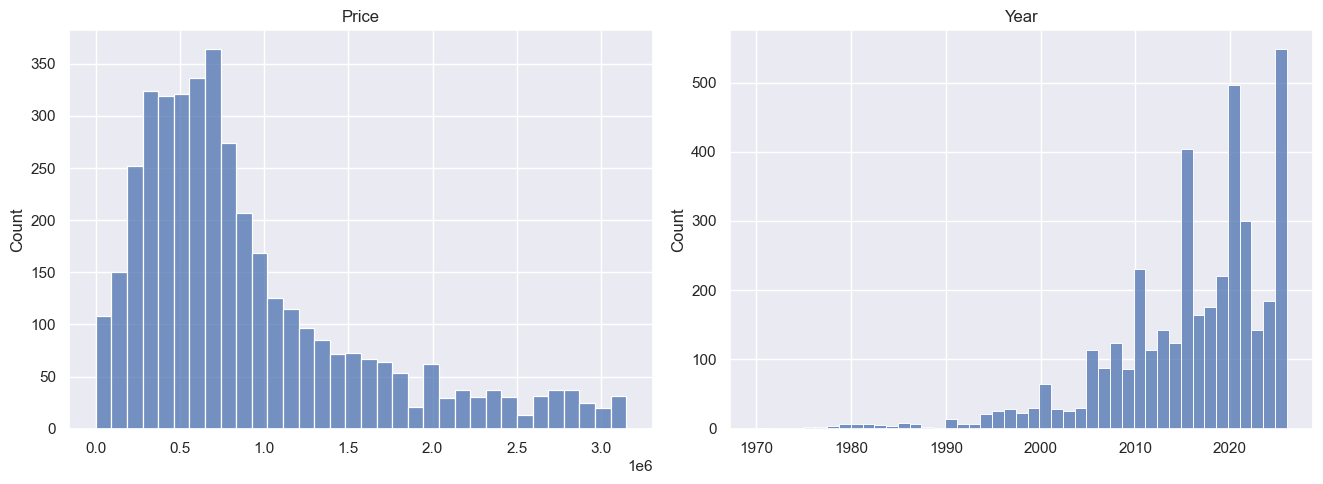

In [8]:
num_cols = df.select_dtypes(include=np.number).columns

num_cols = [col for col in num_cols if "mile" not in col.lower()]

plt.figure(figsize=(20, 5))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.histplot(df[col])
    plt.title(col, fontsize=12)
    plt.xlabel("")
plt.tight_layout()
plt.show()


This visualization consists of two histograms that show the distribution of data across different dimensions:
1. Price Distribution by count of cars (Left Chart)
A histogram with density curve showing how car prices are distributed
2. Year Distribution (Right Chart)
A histogram with density curve showing the number of cars sold each year.

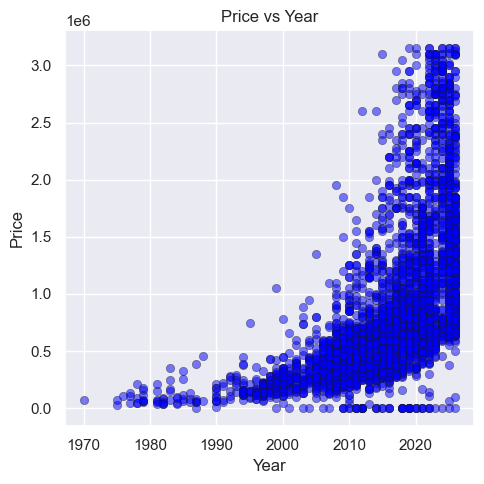

In [9]:
plt.figure(figsize=(5, 5))
plt.scatter(df['Year'], df['Price'], alpha=0.5, c='blue', edgecolors='k', linewidth=0.5)
plt.title('Price vs Year', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

This scatter plot visualizes the relationship between car prices and years from approximately 1970 to 2025 ,
The scatter pattern confirms that recent years haven't just seen price increases they've seen a fundamental restructuring of the market with much greater price diversity than existed historically.

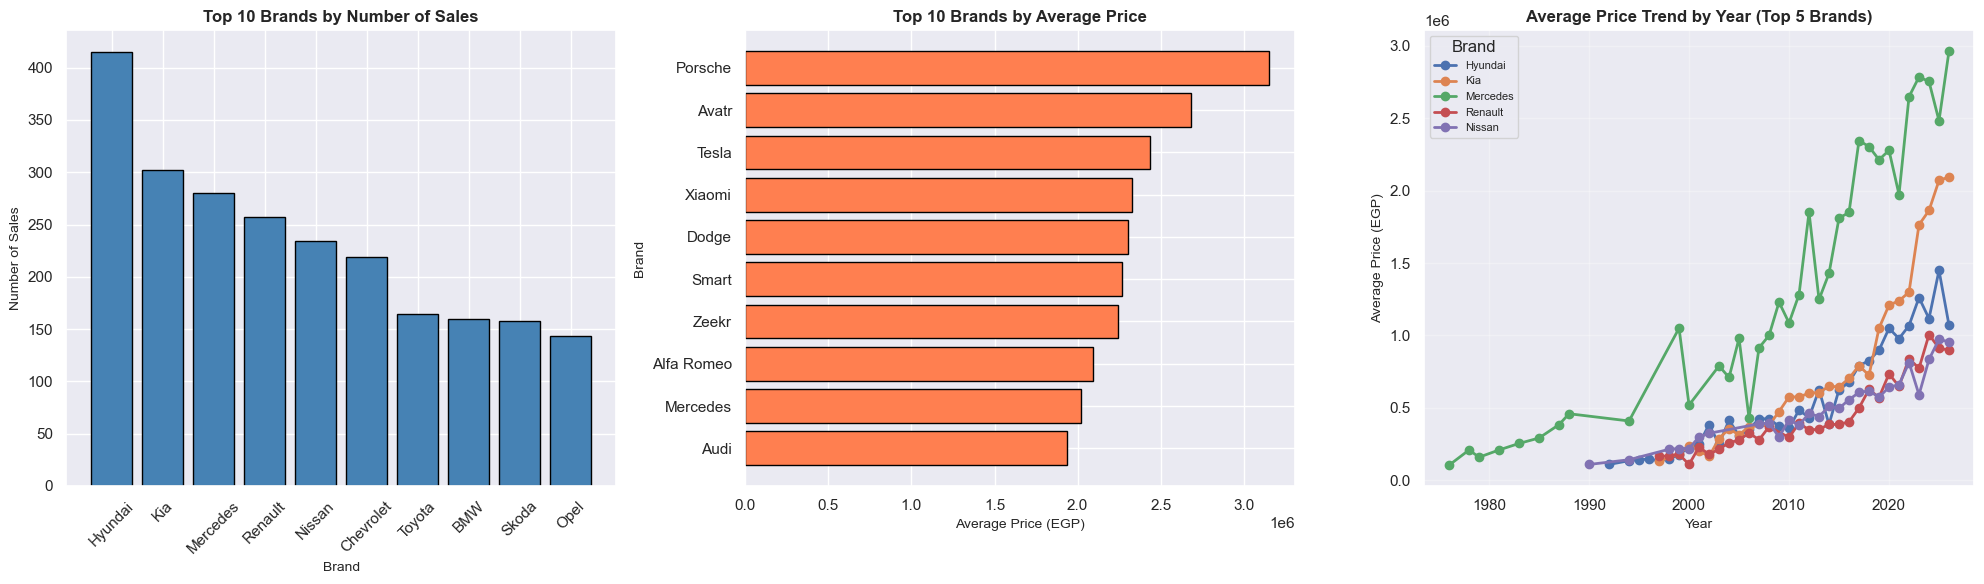

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

top_brands = df['Make_extracted'].value_counts().head(10)
axes[0].bar(top_brands.index, top_brands.values, color='steelblue', edgecolor='black')
axes[0].set_title('Top 10 Brands by Number of Sales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Brand', fontsize=10)
axes[0].set_ylabel('Number of Sales', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

top_brands_price = df.groupby('Make_extracted')['Price'].mean().sort_values(ascending=True).tail(10)
axes[1].barh(top_brands_price.index, top_brands_price.values, color='coral', edgecolor='black')
axes[1].set_title('Top 10 Brands by Average Price', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Price (EGP)', fontsize=10)
axes[1].set_ylabel('Brand', fontsize=10)

top_5_brands = df['Make_extracted'].value_counts().head(5).index
for brand in top_5_brands:
    brand_data = df[df['Make_extracted'] == brand].groupby('Year')['Price'].mean()
    axes[2].plot(brand_data.index, brand_data.values, marker='o', label=brand, linewidth=2)
axes[2].set_title('Average Price Trend by Year (Top 5 Brands)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Year', fontsize=10)
axes[2].set_ylabel('Average Price (EGP)', fontsize=10)
axes[2].legend(title='Brand', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This visualization consists of three complementary charts that analyze the automotive market from different perspectives:
1. Top 10 Brands by Number of Sales (Left Chart)
2. Top 10 Brands by Average Price (Middle Chart)
3. Average Price Trend by Year - Top 5 Brands (Right Chart

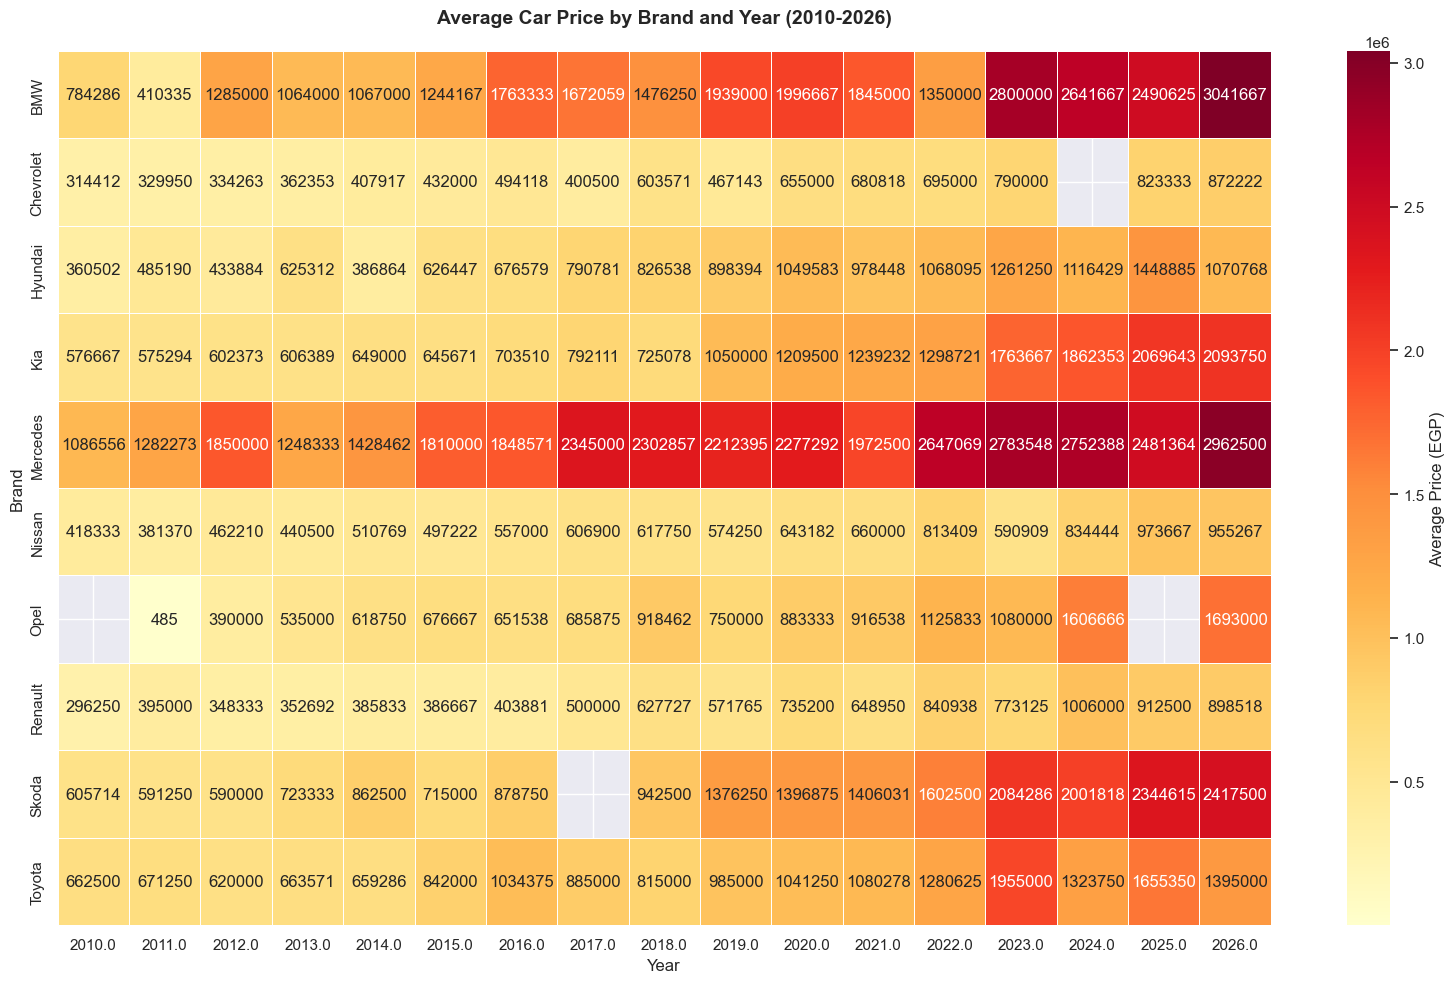

In [11]:
plt.figure(figsize=(16, 10))

top_brands = df['Make_extracted'].value_counts().head(10).index

filtered_df = df[(df['Make_extracted'].isin(top_brands)) & (df['Year'] >= 2010)]

heatmap_data = filtered_df.pivot_table(values='Price', 
                                        index='Make_extracted', 
                                        columns='Year', 
                                        aggfunc='mean')

sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.0f',
            cmap='YlOrRd', 
            linewidths=0.5,
            cbar_kws={'label': 'Average Price (EGP)'})

plt.title('Average Car Price by Brand and Year (2010-2026)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.tight_layout()
plt.show()

This heatmap visualizes the average car prices across different automotive top 10 brands from 2010 to 2026.

##  5. Model

![alt text](../images/image-1.png)

Training samples: 128, Test samples: 32
Epoch 0, MSE: 1.00
Epoch 100, MSE: 0.95
Epoch 200, MSE: 0.50
Epoch 300, MSE: 0.39
Epoch 400, MSE: 0.37
Epoch 500, MSE: 0.37
Epoch 600, MSE: 0.37
Epoch 700, MSE: 0.37
Epoch 800, MSE: 0.37
Epoch 900, MSE: 0.37
Epoch 1000, MSE: 0.36
Epoch 1100, MSE: 0.36
Epoch 1200, MSE: 0.36
Epoch 1300, MSE: 0.36
Epoch 1400, MSE: 0.36
Epoch 1500, MSE: 0.36
Epoch 1600, MSE: 0.36
Epoch 1700, MSE: 0.36
Epoch 1800, MSE: 0.36
Epoch 1900, MSE: 0.36

Test RMSE: 384,021 EGP
Test R²: 0.7826



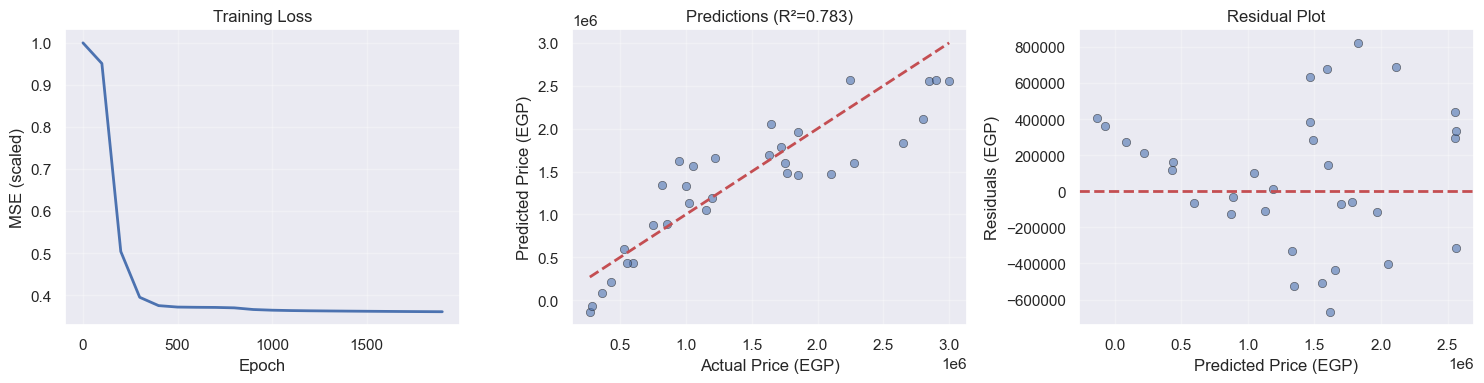

In [17]:
# Car Price Prediction Neural Network

# def sigmoid(x):
#     """Sigmoid activation (0-1 range)"""
#     return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def relu(x):
    """ReLU activation (better for regression) range(o, infinity)"""
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

class CarPriceNN:
    """
    A simple feedforward neural network for car price prediction.
    Architecture:
    - Input layer: 2 neurons (Age, Mileage)
    - Hidden layer: 8 neurons, ReLU activation
    - Output layer: 1 neuron (Price), linear activation

    neural network
    A neuron takes inputs, does some math with them, and produces one output.
    ex: a neuron that takes two inputs
    inputs: x1, x2
    weights: w1, w2
    bias: b
    output: y = w1*x1 + w2*x2 + b
    """
    def __init__(self, input_size=2, hidden_size=8, learning_rate=0.001):
        # Weights
        self.W1 = np.random.normal(0, 0.01, (input_size, hidden_size))
        self.W2 = np.random.normal(0, 0.01, (hidden_size, 1))

        #biases
        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, 1))
   
        # Learning rate
        self.lr = learning_rate
        self.losses = []
        
    def forward(self, X):
        """
        Forward pass
        x: input features
        returns: predicted prices
        preforms calculations through the network layers
        """
        self.h1 = X.dot(self.W1) + self.b1 # Hidden layer
        self.a1 = relu(self.h1) # Activation function
        self.h2 = self.a1.dot(self.W2) + self.b2 # Hidden/Output layer
        return self.h2  # Linear output for regression
    
    def backward(self, X, y, output):
        """
        Backpropagation
        x: input features
        y: target prices
        output: predicted prices
        preforms weight updates based on loss
        """
        m = X.shape[0]
        
        # Output layer gradients
        dz2 = output - y # Derivative of loss w.r.t. output
        dW2 = (1/m) * self.a1.T.dot(dz2) # Weight gradient
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True) # Bias gradient
        
        # Hidden layer gradients
        da1 = dz2.dot(self.W2.T) # Derivative w.r.t. hidden layer activations
        dz1 = da1 * relu_derivative(self.h1) # Apply ReLU derivative
        dW1 = (1/m) * X.T.dot(dz1) # Weight gradient
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True) # Bias gradient
        
        # Update weights
        self.W1 -= self.lr * dW1 # Update weights
        self.b1 -= self.lr * db1 # Update biases
        self.W2 -= self.lr * dW2 # Update weights
        self.b2 -= self.lr * db2 # Update biases
    
    def train(self, X, y, epochs=1000, batch_size=32, verbose=True):
        """
        Mini-batch training
        x: input features
        y: target prices
        epochs: number of training iterations
        batch_size: size of each mini-batch
        verbose: print loss every 100 epochs
        Trains the neural network using mini-batch gradient descent.
        """
        n_samples = X.shape[0]
        for epoch in range(epochs):
            # Shuffle data to create mini-batches
            indices = np.random.permutation(n_samples) # Shuffle indices
            X_shuffled = X[indices] # Shuffle features
            y_shuffled = y[indices] # Shuffle targets
            
            # Mini-batch gradient descent
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size] # Mini-batch features
                y_batch = y_shuffled[i:i+batch_size] # Mini-batch targets
                
                output = self.forward(X_batch) # Forward pass 
                self.backward(X_batch, y_batch, output) # Backpropagation
            
            # Track loss
            if epoch % 100 == 0:
                y_pred = self.forward(X)
                loss = np.mean((y - y_pred)**2)
                self.losses.append(loss)
                if verbose:
                    print(f"Epoch {epoch}, MSE: {loss:.2f}")
    
    def predict(self, X):
        """
        Make predictions
        x: input features
        returns: predicted prices
        """
        return self.forward(X)
                
# ========== PREPARE BMW DATA ==========
df_bmw = df[df['Make_extracted'] == 'BMW'].copy() #filtering data_cleaned to be bmw cars only
df_bmw['Year'] = pd.to_numeric(df_bmw['Year'], errors='coerce') #ensure converting year to numeric
df_bmw['Mileage_in_KM'] = pd.to_numeric(df_bmw['Mileage_in_KM'], errors='coerce') #ensure converting mileage to numeric
df_bmw['Price'] = pd.to_numeric(df_bmw['Price'], errors='coerce') #ensure converting price to numeric
df_bmw = df_bmw.dropna(subset=['Year', 'Mileage_in_KM', 'Price']) #drop rows with missing values in these columns

# Features: Age and Mileage (in thousands)
CURRENT_YEAR = 2026
df_bmw['Age'] = CURRENT_YEAR - df_bmw['Year']
df_bmw['Mileage_k'] = df_bmw['Mileage_in_KM'] / 1000.0

X = df_bmw[['Age', 'Mileage_k']].values
y = df_bmw['Price'].values.reshape(-1, 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler_X = StandardScaler() #feature scaler to standardize features to mean 0 and std 1 aka z-score normalization :)
scaler_y = StandardScaler() #target scaler to standardize target variable to mean 0 and std 1 
X_train_scaled = scaler_X.fit_transform(X_train) #scaling training features
X_test_scaled = scaler_X.transform(X_test) #scaling test features
y_train_scaled = scaler_y.fit_transform(y_train) #scaling training targets
y_test_scaled = scaler_y.transform(y_test) #scaling test targets

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# ========== TRAIN MODEL ==========
model = CarPriceNN(input_size=2, hidden_size=8, learning_rate=0.01)
model.train(X_train_scaled, y_train_scaled, epochs=2000, batch_size=32, verbose=True)

# ========== EVALUATE ==========
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"Test RMSE: {rmse:,.0f} EGP")
print(f"Test R²: {r2:.4f}")
print(f"{'='*50}\n")

# ========== VISUALIZATIONS ==========
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(range(0, len(model.losses)*100, 100), model.losses, linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE (scaled)')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
axes[1].scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price (EGP)')
axes[1].set_ylabel('Predicted Price (EGP)')
axes[1].set_title(f'Predictions (R²={r2:.3f})')
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = y_test.flatten() - y_pred.flatten()
axes[2].scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[2].axhline(0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted Price (EGP)')
axes[2].set_ylabel('Residuals (EGP)')
axes[2].set_title('Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== PREDICTION ==========
def predict_price(age, mileage_km):
    """Predict BMW price given age and mileage"""
    mileage_k = mileage_km / 1000.0
    X_new = np.array([[age, mileage_k]])
    X_new_scaled = scaler_X.transform(X_new)
    y_new_scaled = model.predict(X_new_scaled)
    y_new = scaler_y.inverse_transform(y_new_scaled)
    return max(0, y_new[0, 0])  # Ensure non-negative


### testing the model with user input

In [18]:
age_input = int(input("\nEnter car age (years): "))
km_input = int(input("Enter mileage (km): "))
price_pred = predict_price(age_input, km_input)
print(f"\nPredicted Price for {age_input} years old car with {km_input} km: {price_pred:,.0f} EGP")


Predicted Price for 12 years old car with 100000 km: 1,245,636 EGP
